In [1]:
!pip install tensorflow tensorflow_io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 15.0 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import pywt
import tensorflow as tf
import tensorflow_io as tfio
from tqdm import tqdm

# Define function to load wav files
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

POS_DIR = '/content/drive/MyDrive/aidataset/gunshot'
NEG_DIR = '/content/drive/MyDrive/aidataset/nongunshot'

# Function to extract features
def extract_features(wav_data):
    # Example feature extraction, replace with your desired features
    # Here we're using the mean and standard deviation of the signal
    mean = np.mean(wav_data)
    std_dev = np.std(wav_data)
    return [mean, std_dev]

# Positive examples
positive_files = tf.data.Dataset.list_files(POS_DIR + '/*.wav')
positive_data = []
for file in tqdm(positive_files, desc='Processing positive examples'):
    wav_data = load_wav_16k_mono(file)
    features = extract_features(wav_data.numpy())
    positive_data.append(features)

# Negative examples
negative_files = tf.data.Dataset.list_files(NEG_DIR + '/*.wav')
negative_data = []
for file in tqdm(negative_files, desc='Processing negative examples'):
    wav_data = load_wav_16k_mono(file)
    features = extract_features(wav_data.numpy())
    negative_data.append(features)

# Create DataFrame for positive examples
pos_df = pd.DataFrame(positive_data, columns=['mean', 'std_dev'])
pos_df['label'] = 1

# Create DataFrame for negative examples
neg_df = pd.DataFrame(negative_data, columns=['mean', 'std_dev'])
neg_df['label'] = 0

# Concatenate positive and negative examples
data = pd.concat([pos_df, neg_df], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display the size of the dataset
print("Dataset size:", len(data))

# Repeat positive examples to match the number of negatives
num_positives = len(pos_df)
num_negatives = len(neg_df)
repeat_count = num_negatives // num_positives
remainder = num_negatives % num_positives

repeated_positives = pd.concat([pos_df] * repeat_count, ignore_index=True)
repeated_positives = pd.concat([repeated_positives, pos_df.head(remainder)], ignore_index=True)

# Combine positive and negative examples
balanced_data = pd.concat([repeated_positives, neg_df], ignore_index=True)

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

# Display the size of the balanced dataset
print("Balanced dataset size:", len(balanced_data))



Processing negative examples: 100%|██████████| 2000/2000 [06:20<00:00,  5.25it/s]

Dataset size: 2660
Balanced dataset size: 4000


2000
Mean for positive class: mean      -0.000067
std_dev    0.156643
dtype: float32
Standard deviation for positive class: mean       0.000853
std_dev    0.090936
dtype: float32
Mean for negative class: mean      -0.000143
std_dev    0.091827
dtype: float32
Standard deviation for negative class: mean       0.006884
std_dev    0.086528
dtype: float32
Interclass distance: 0.0648161


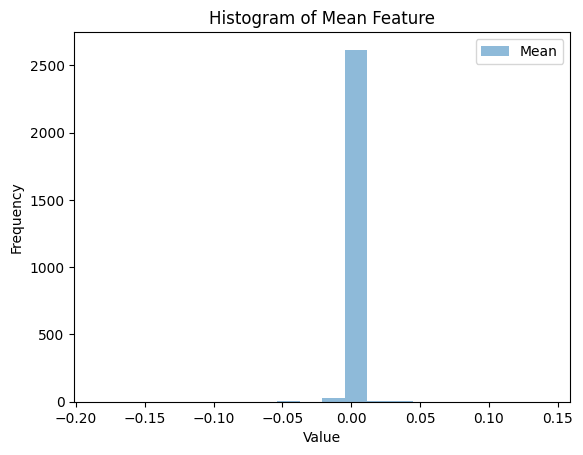

Mean: -0.00012375982
Variance: 3.581242e-05


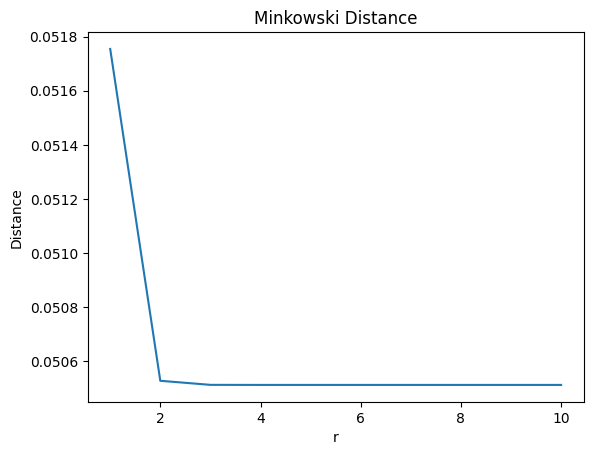

Accuracy of kNN: 0.7431077694235589


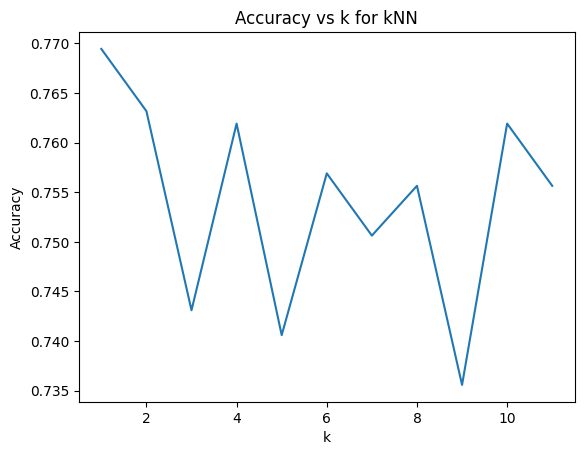

Confusion Matrix:
 [[516  89]
 [116  77]]
Precision: 0.463855421686747
Recall: 0.39896373056994816
F1 Score: 0.4289693593314763


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from matplotlib import pyplot as plt

print(len(repeated_positives))
# A1. Evaluate intraclass spread and interclass distances
pos_mean = np.mean(repeated_positives[['mean', 'std_dev']], axis=0)
neg_mean = np.mean(neg_df[['mean', 'std_dev']], axis=0)
pos_std = np.std(repeated_positives[['mean', 'std_dev']], axis=0)
neg_std = np.std(neg_df[['mean', 'std_dev']], axis=0)
interclass_distance = np.linalg.norm(pos_mean - neg_mean)
print("Mean for positive class:", pos_mean)
print("Standard deviation for positive class:", pos_std)
print("Mean for negative class:", neg_mean)
print("Standard deviation for negative class:", neg_std)
print("Interclass distance:", interclass_distance)

#A2 Plot histogram for 1 feature
plt.hist(data['mean'], bins=20, alpha=0.5, label='Mean')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Feature')
plt.legend()
plt.show()

# Calculate mean and variance
mean = np.mean(data['mean'])
variance = np.var(data['mean'])
print("Mean:", mean)
print("Variance:", variance)

# A3. Calculate Minkowski distance for two feature vectors
feature_vector1 = data.loc[0, ['mean', 'std_dev']]
feature_vector2 = data.loc[1, ['mean', 'std_dev']]
minkowski_distances = []
for r in range(1, 11):
    distance = np.linalg.norm(feature_vector1 - feature_vector2, ord=r)
    minkowski_distances.append(distance)
plt.plot(range(1, 11), minkowski_distances)
plt.xlabel('r')
plt.ylabel('Distance')
plt.title('Minkowski Distance')
plt.show()

# A4. Divide dataset into train and test sets
X = data[['mean', 'std_dev']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# A5. Train kNN classifier (k = 3)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

# A6. Test accuracy of kNN
accuracy = neigh.score(X_test, y_test)
print("Accuracy of kNN:", accuracy)

# A7. Use predict() function to study prediction behavior
predictions = neigh.predict(X_test)
